In [1]:
import numpy as np
import cv2
import os
import scipy.io as sio

In [2]:
import matplotlib.pyplot as plt

In [3]:
from skdemo import imshow_all

In [4]:
import seaborn as sns

In [5]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        f = os.path.join(folder,filename)
        img =cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

In [6]:
path1 = 'sample3_left_edge' # folder of the frist CT volumn
path2 = 'sample3_right_edge'# folder of the second CT volumn

In [7]:
data_left = load_images_from_folder(path1)
data_right = load_images_from_folder(path2)

In [8]:
data_left = np.swapaxes(data_left,1, 2)
data_right = np.swapaxes(data_right,1, 2)

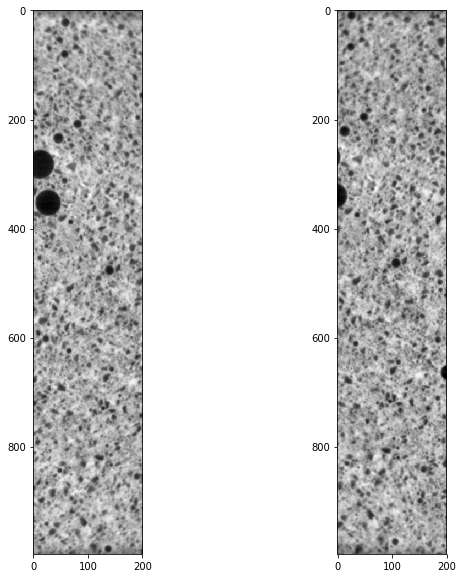

In [9]:
fig, axs = plt.subplots(1,2, figsize = (10,10))
axs[0].imshow(data_left[:,-200:,9], cmap = 'gray')
axs[1].imshow(data_right[:,0:200,20], cmap = 'gray')

In [10]:
image0 = data_left[:,-200:,9]
image1 = data_right[:,0:200,20]

c:\program files\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


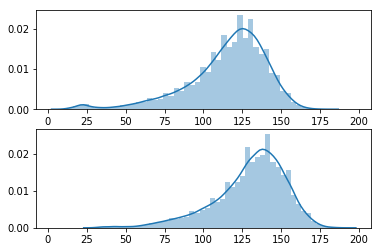

In [11]:
#fig, axs = plt.subplots(2,1, figsize = (5,10))
ax1 = plt.subplot(211)
sns.distplot(image0.ravel(),ax=ax1)
ax2 = plt.subplot(212, sharex=ax1)
sns.distplot(image1.ravel(),ax=ax2)

In [12]:
def _match_cumulative_cdf(source, template):
    """
    Return modified source array so that the cumulative density function of
    its values matches the cumulative density function of the template.
    """
    src_values, src_unique_indices, src_counts = np.unique(source.ravel(),
                                                           return_inverse=True,
                                                           return_counts=True)
    tmpl_values, tmpl_counts = np.unique(template.ravel(), return_counts=True)

    # calculate normalized quantiles for each array
    src_quantiles = np.cumsum(src_counts) / source.size
    tmpl_quantiles = np.cumsum(tmpl_counts) / template.size

    interp_a_values = np.interp(src_quantiles, tmpl_quantiles, tmpl_values)
    return interp_a_values[src_unique_indices].reshape(source.shape)



def match_histograms(image, reference, multichannel=False):
    """Adjust an image so that its cumulative histogram matches that of another.

    The adjustment is applied separately for each channel.

    Parameters
    ----------
    image : ndarray
        Input image. Can be gray-scale or in color.
    reference : ndarray
        Image to match histogram of. Must have the same number of channels as
        image.
    multichannel : bool, optional
        Apply the matching separately for each channel.

    Returns
    -------
    matched : ndarray
        Transformed input image.

    Raises
    ------
    ValueError
        Thrown when the number of channels in the input image and the reference
        differ.

    References
    ----------
    .. [1] http://paulbourke.net/miscellaneous/equalisation/

    """
    shape = image.shape
    image_dtype = image.dtype

    if image.ndim != reference.ndim:
        raise ValueError('Image and reference must have the same number of channels.')

    if multichannel:
        if image.shape[-1] != reference.shape[-1]:
            raise ValueError('Number of channels in the input image and reference '
                             'image must match!')

        matched = np.empty(image.shape, dtype=image.dtype)
        for channel in range(image.shape[-1]):
            matched_channel = _match_cumulative_cdf(image[..., channel], reference[..., channel])
            matched[..., channel] = matched_channel
    else:
        matched = _match_cumulative_cdf(image, reference)

    return matched

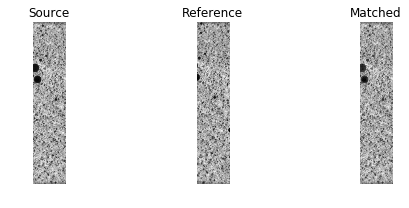

In [13]:
image = image0
reference = image1
matched = match_histograms(image, reference, multichannel=False)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

plt.tight_layout()
plt.show()

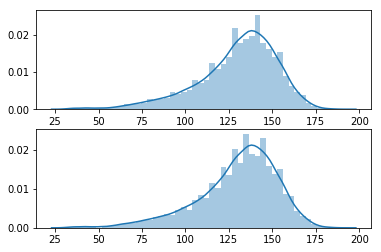

In [14]:
#fig, axs = plt.subplots(2,1, figsize = (5,10))
ax1 = plt.subplot(211)
sns.distplot(reference.ravel(),ax=ax1)
ax2 = plt.subplot(212, sharex=ax1)
sns.distplot(matched.ravel(),ax=ax2)

In [42]:
image0 = matched.astype(np.uint8)
image0 = np.divide(image0,2)
image1 = reference.astype(np.uint8)
image1 = np.divide(image1,2)

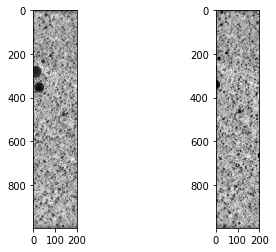

In [43]:
#fig, axs = plt.subplots(2,1, figsize = (5,10))
ax1 = plt.subplot(121)
plt.imshow(image0)
ax2 = plt.subplot(122, sharex=ax1)
plt.imshow(image1)


In [44]:
from skimage.feature import ORB, match_descriptors

orb = ORB(n_keypoints=1000, fast_threshold=0.05)

orb.detect_and_extract(image0)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(image1)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

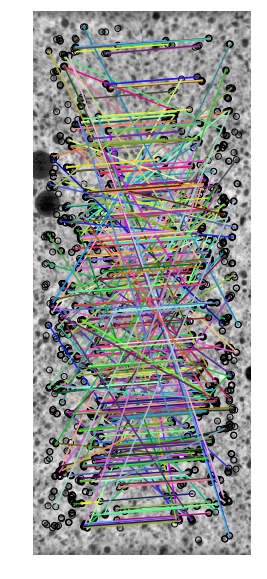

In [45]:
from skimage.feature import plot_matches

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12)
ax.axis('off');

In [46]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.feature import plot_matches

# Select keypoints from the source (image to be registered)
# and target (reference image)
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust, inliers = ransac((src, dst), ProjectiveTransform,
                               min_samples=4, residual_threshold=2)

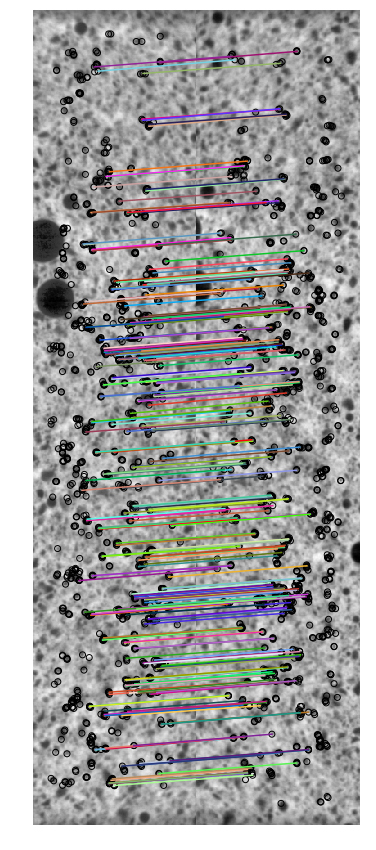

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12[inliers])
ax.axis('off');

In [49]:
from skimage.transform import SimilarityTransform

r, c = image1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners = model_robust(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners, corners))

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)

output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1])

In [50]:
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from skimage.transform import warp

offset = SimilarityTransform(translation=-corner_min)

image0_ = warp(image0, offset.inverse,
               output_shape=output_shape, cval=-1)

image1_ = warp(image1, (model_robust + offset).inverse,
               output_shape=output_shape, cval=-1)

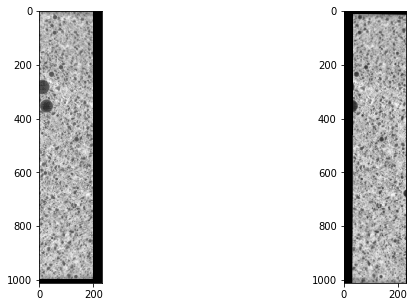

In [51]:
imshow_all(image0_, image1_)

In [52]:
np.shape(image0_)

(1011, 233)

In [53]:
def add_alpha(image, background=-1):
    """Add an alpha layer to the image.
    
    The alpha layer is set to 1 for foreground and 0 for background.
    """
    return np.dstack((gray2rgb(image), (image != background)))

image0_alpha = add_alpha(image0_)
image1_alpha = add_alpha(image1_)

merged = (image0_alpha + image1_alpha)
alpha = merged[..., 3]

# The summed alpha layers give us an indication of how many
# images were combined to make up each pixel.  Divide by the
# number of images to get an average.
merged /= np.maximum(alpha, 1)[..., np.newaxis]
merged = merged[..., :3]

In [63]:
def add_alpha(image, background=-1):
    """Add an alpha layer to the image.
    
    The alpha layer is set to 1 for foreground and 0 for background.
    """
    return np.dstack((image, (image != background)))

image0_alpha = add_alpha(image0_)
image1_alpha = add_alpha(image1_)



In [64]:
np.shape(image0_alpha)

(1011, 233, 2)

In [65]:
merged = (image0_alpha + image1_alpha)
merged = (image1_alpha[:,:,0]+image0_alpha[:,:,0])/(image1_alpha[:,:,1]+image0_alpha[:,:,1])

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


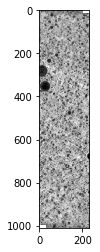

In [66]:
plt.imshow(merged)